In [1]:
# Acquire practical understanding of diffusion model architectures, data processing,
# model training, and performance evaluatoin

# Implement, train and evaluate diffusion models using Keras

In [1]:
! pip install numpy
! pip install matplotlib

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input,Conv2D, Flatten, Dense,Reshape, Convolution2DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

In [3]:
# load the dataset
(x_train,_),(x_test,_) = mnist.load_data()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [4]:
#normalize the pixel values
x_train = x_train.astype('float32')/255.
x_test = x_test.astype("float32")/255.

#Expand dimensions to match the input shape
x_train=np.expand_dims(x_train,axis =-1)
x_test = np.expand_dims(x_test, axis = -1)

# expand 해주는 이유 -> Mnist 데이터의 기본적인 shape은 x_train => (6000,28,28)
#                                                          (이미지의 수, 세로크기, 가로 크기)
# 딥러닝 input shape 의 규칙 : batch_size, height, width, channels 형태의 4d 가 규칙임.
# 그래서 input의 shape 을 expand 해서 딥러닝에 학습시키기 위한 적절한 input 형태가 되도록 생성하는것
#                                                      x_train => (6000,28,28,1) 로 변환

In [16]:
#Add noise to the data
noise_factor = 0.5
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)

# Clip the values to the range [0, 1]
# clip 함수의 역할 -> 배열의 값이 주어진 범위안에 있도록 강제 수정
# why? 노이즈를 추가하면 이미지의 픽셀값이 0-1 범위 사이를 벗어날 수 있는데
# 이를 막고자 cliping 해서 0.1 -1.0 사이의 값으로 조절
x_train_noisy = np.clip(x_train_noisy, 0.0, 1.0)
x_test_noisy = np.clip(x_test_noisy, 0.0, 1.0)


In [6]:
# Build the diffusion model
# 1. define the encoder
# 2. define the bottleneck
# 3. define the decoder
# 4. compile the model

In [17]:
from tensorflow.keras.layers import Convolution2DTranspose
# Define the diffusion model architecture with reduced complexity
input_layer = Input(shape=(28, 28, 1))
x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_layer)  # 특징추출
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)  # 특징추출
x = Flatten()(x) #dense 는 1차원벡터만 받기떄문에 평탄화 수행
x = Dense(64, activation='relu')(x)  # 정보압축(인코딩)
x = Dense(28*28*32, activation='relu')(x)  # 정보복원(디코딩 준비 )
x = Reshape((28, 28, 32))(x) # 이미지 shape으로 변경
x = Convolution2DTranspose(32, (3, 3), activation='relu', padding='same')(x)  # 이미지 복원
x = Convolution2DTranspose(16, (3, 3), activation='relu', padding='same')(x)  # 이미지 복원
output_layer = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)


diffusion_model = Model(input_layer, output_layer)

# Compile the model with mixed precision and a different loss function
diffusion_model.compile(optimizer='adam', loss='mean_squared_error')  # Using MSE for regression tasks

# Summary of the optimized model
diffusion_model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 28, 28, 16)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 28, 28, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │     1,605,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 25088)          │     1,630,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_3 (Reshape)             │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 28, 28, 32)     │         9,248 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_3              │ (None, 28, 28, 16)     │         4,624 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 28, 28, 1)      │           145 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,255,233 (12.42 MB)

 Trainable params: 3,255,233 (12.42 MB)

 Non-trainable params: 0 (0.00 B)

In [18]:
# Cache and prefetch the data using TensorFlow data pipelines for faster loading
train_dataset = tf.data.Dataset.from_tensor_slices((x_train_noisy, x_train))
train_dataset = train_dataset.cache().batch(64).prefetch(tf.data.AUTOTUNE)  # Reduced batch size

val_dataset = tf.data.Dataset.from_tensor_slices((x_test_noisy, x_test))
val_dataset = val_dataset.cache().batch(64).prefetch(tf.data.AUTOTUNE)  # Reduced batch size


In [19]:
early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

# train model
diffusion_model.fit(
    train_dataset,
    epochs = 3,
    shuffle = True,
    validation_data = val_dataset,
    callbacks = [early_stopping]
)

Epoch 1/3
938/938 ━━━━━━━━━━━━━━━━━━━━ 305s 322ms/step - loss: 0.0186 - val_loss: 1.7525e-06
Epoch 2/3
938/938 ━━━━━━━━━━━━━━━━━━━━ 345s 346ms/step - loss: 1.7309e-06 - val_loss: 1.7525e-06
Epoch 3/3
938/938 ━━━━━━━━━━━━━━━━━━━━ 312s 333ms/step - loss: 1.7309e-06 - val_loss: 1.7525e-06


313/313 ━━━━━━━━━━━━━━━━━━━━ 15s 47ms/step


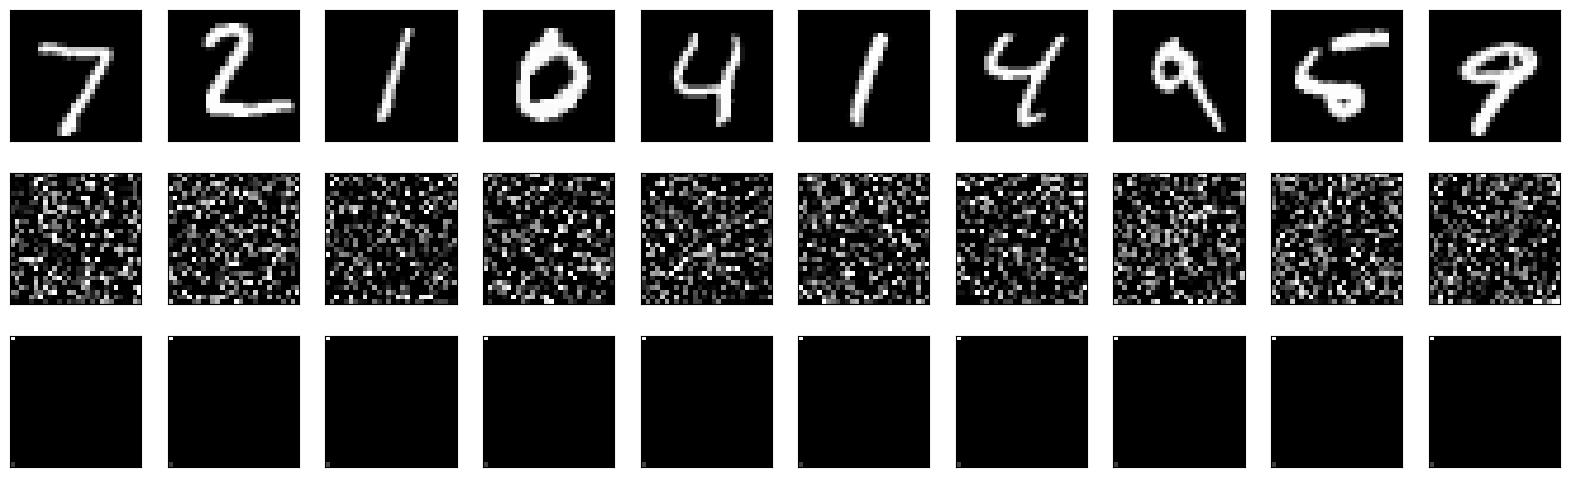

In [20]:
import matplotlib.pyplot as plt

# Predict the denoised images
denoised_images = diffusion_model.predict(x_test_noisy)

# Visualize the results
n = 10  # Number of digits to display
plt.figure(figsize=(20, 6))
for i in range(n):
    # Display original
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display noisy
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(x_test_noisy[i].reshape(28, 28), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display denoised
    ax = plt.subplot(3, n, i + 1 + 2*n)
    plt.imshow(denoised_images[i].reshape(28, 28), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [22]:
# fine-turn the diffusion model - 가장 마지막 데이터에서 4개정도만 바꿔서 미세소정
for layer in diffusion_model.layers[-4:]:
    layer.trainable = True

# compile the model origin
diffusion_model.compile(optimizer = 'adam', loss = 'binary_crossentropy')

#train the model again
#denoisy 모델을 fit 시킬때와 구조가 다른 이유
# 1. x_train_noisy = 모델에 노이즈가 추가된 입력 이미지
#    x_train = 깨끗한 정답 데이터
# fine-tuning 은 이미 어느정도 학습된 데이터를 더 정밀하게 조정하는 과정이기에
# 입력과 정답이 모다 명확하게 구분될 수 있으므로, 정답데이터를 제공해
# 이미 훈련된 부분을 수정하거나 더욱 정밀한 조정을 하는것이므로 x_train 이 추가로 제공됨
# 2.  batch_size = 더 섬세하게 조정하기위해 기본값인 32 말고 64 를 넣기 위해
# 3.  earlystopping 이 없는 이유 => 말했듯이 이미 학습된 모델을 가지고 fine-tuning 을
#     하는 것이기 때문에 굳이 빨리 끝낼 이유가 없다, 학습을 더 오래돌려 완벽하게 조정
#     하기 위함인데 굳이 일찍끝낸다는건 말이 안됨.
diffusion_model.fit(
    x_train_noisy,
    x_train,
    epochs = 10,
    shuffle = True,
    batch_size = 64,
    validation_data = (x_test_noisy, x_test),
)

Epoch 1/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 304s 320ms/step - loss: 0.0057 - val_loss: 0.0040
Epoch 2/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 326s 324ms/step - loss: 0.0040 - val_loss: 0.0040
Epoch 3/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 330s 333ms/step - loss: 0.0040 - val_loss: 0.0040
Epoch 4/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 313s 323ms/step - loss: 0.0040 - val_loss: 0.0040
Epoch 5/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 330s 332ms/step - loss: 0.0040 - val_loss: 0.0040
Epoch 6/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 321s 331ms/step - loss: 0.0040 - val_loss: 0.0040
Epoch 7/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 318s 326ms/step - loss: 0.0040 - val_loss: 0.0040
Epoch 8/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 328s 333ms/step - loss: 0.0040 - val_loss: 0.0040
Epoch 9/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 320s 331ms/step - loss: 0.0040 - val_loss: 0.0040
Epoch 10/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 321s 330ms/step - loss: 0.0040 - val_loss: 0.0040


313/313 ━━━━━━━━━━━━━━━━━━━━ 16s 51ms/step


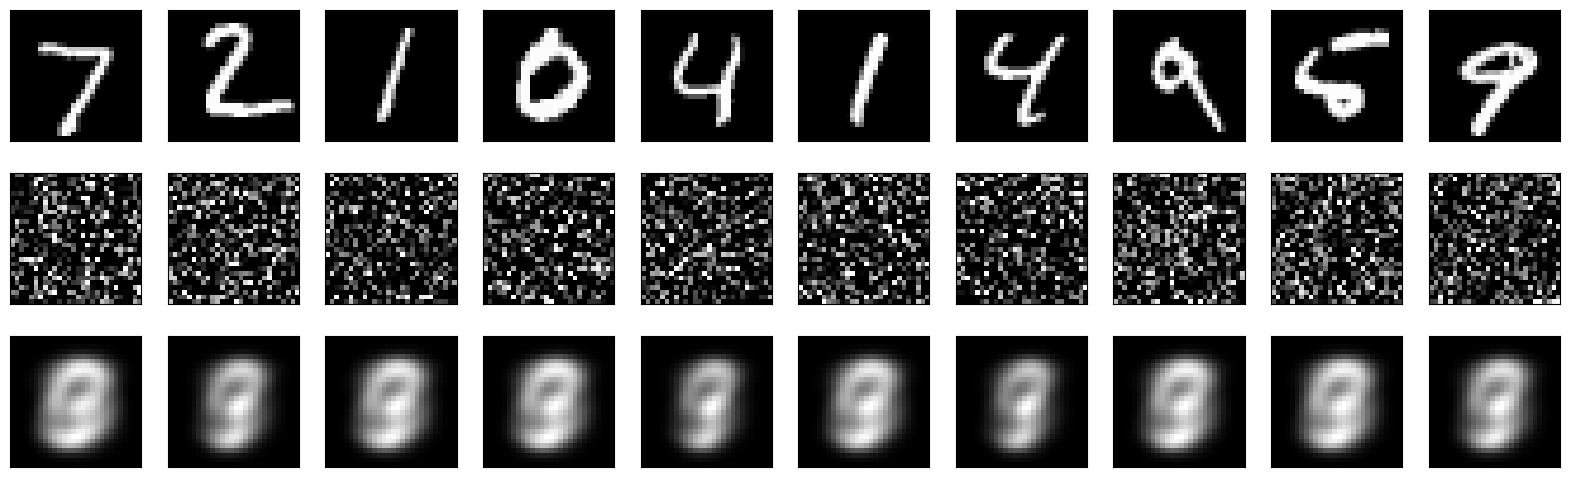

In [23]:
import matplotlib.pyplot as plt

# Predict the denoised images
denoised_images = diffusion_model.predict(x_test_noisy)

# Visualize the results
n = 10  # Number of digits to display
plt.figure(figsize=(20, 6))
for i in range(n):
    # Display original
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display noisy
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(x_test_noisy[i].reshape(28, 28), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display denoised
    ax = plt.subplot(3, n, i + 1 + 2*n)
    plt.imshow(denoised_images[i].reshape(28, 28), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

***첫번째 모델 학습 결과는 아예 검은색이였던 반면에 두번쨰 모델 학습결과는 정답을 맞추기 위해 숫자의 형태는 보이나 여전히 정답과는 거리가 먼 것을 보이고 있음***

In [ ]:
#Exercise 1 - Modify the noise factor
#         2 - add more layers to the model
#           [Add an additional Conv2D layer with 128 filters in the enocoder
#            Add an additinial Conv2DTranspose layer with 128 filters in the decoder
#            Rebuild, comfile, and train the model]


In [5]:
new_noise_factor = 0.3 # new noise factor
x_train_noisy = x_train + new_noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
x_test_noisy = x_test + new_noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)

x_train_noisy = np.clip(x_train_noisy, 0.0,1.0)
x_test_noisy = np.clip(x_test_noisy, 0.0, 1.0)

In [6]:
from tensorflow.keras.layers import Convolution2DTranspose

# Define the diffusion model architecture with reduced complexity
input_layer = Input(shape=(28, 28, 1))
x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_layer)  # 특징추출
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)  # 특징추출
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)  # Add layer
x = Flatten()(x) #dense 는 1차원벡터만 받기떄문에 평탄화 수행
x = Dense(64, activation='relu')(x)  # 정보압축(인코딩)
x = Dense(28*28*32, activation='relu')(x)  # 정보복원(디코딩 준비 )
x = Reshape((28, 28, 32))(x) # 이미지 shape으로 변경
x = Convolution2DTranspose(128, (3, 3), activation='relu', padding='same')(x)  # 이미지 복원
x = Convolution2DTranspose(64, (3, 3), activation='relu', padding='same')(x)  # 이미지 복원
x = Convolution2DTranspose(32, (3, 3), activation='relu', padding='same')(x)  # Add layer
output_layer = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)


new_diffusion_model = Model(input_layer, output_layer)

# Compile the model with mixed precision and a different loss function
new_diffusion_model.compile(optimizer='adam', loss='mean_squared_error')  # Using MSE for regression tasks

# Summary of the optimized model
new_diffusion_model.summary()



Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 28, 28, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     6,422,592 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 25088)          │     1,630,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 28, 28, 128)    │        36,992 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 28, 28, 64)     │        73,792 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 28, 28, 32)     │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 1)      │           289 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,275,521 (31.57 MB)

 Trainable params: 8,275,521 (31.57 MB)

 Non-trainable params: 0 (0.00 B)

In [7]:
# Cache and prefetch the data using TensorFlow data pipelines for faster loading
train_dataset = tf.data.Dataset.from_tensor_slices((x_train_noisy, x_train))
train_dataset = train_dataset.cache().batch(64).prefetch(tf.data.AUTOTUNE)  # Reduced batch size

val_dataset = tf.data.Dataset.from_tensor_slices((x_test_noisy, x_test))
val_dataset = val_dataset.cache().batch(64).prefetch(tf.data.AUTOTUNE)  # Reduced batch size


In [8]:
#retrain the model
new_diffusion_model.fit(
    x_train_noisy,
    x_train,
    epochs = 50,
    shuffle = True,
    batch_size = 128,
    validation_data = (x_test_noisy, x_test),
)


Epoch 1/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 32s 51ms/step - loss: 0.0815 - val_loss: 0.0260
Epoch 2/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 19s 40ms/step - loss: 0.0247 - val_loss: 0.0204
Epoch 3/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 21s 41ms/step - loss: 0.0199 - val_loss: 0.0183
Epoch 4/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 21s 41ms/step - loss: 0.0183 - val_loss: 0.0176
Epoch 5/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 19s 41ms/step - loss: 0.0174 - val_loss: 0.0161
Epoch 6/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 20s 40ms/step - loss: 0.0158 - val_loss: 0.0154
Epoch 7/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 19s 40ms/step - loss: 0.0149 - val_loss: 0.0149
Epoch 8/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 21s 41ms/step - loss: 0.0144 - val_loss: 0.0146
Epoch 9/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 20s 40ms/step - loss: 0.0139 - val_loss: 0.0143
Epoch 10/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 21s 41ms/step - loss: 0.0135 - val_loss: 0.0144
Epoch 11/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 21s 41ms/step - loss: 0.0132 - val_loss: 0.0142
Epoch 12/50
469/469 ━━━━━━━━━━

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step


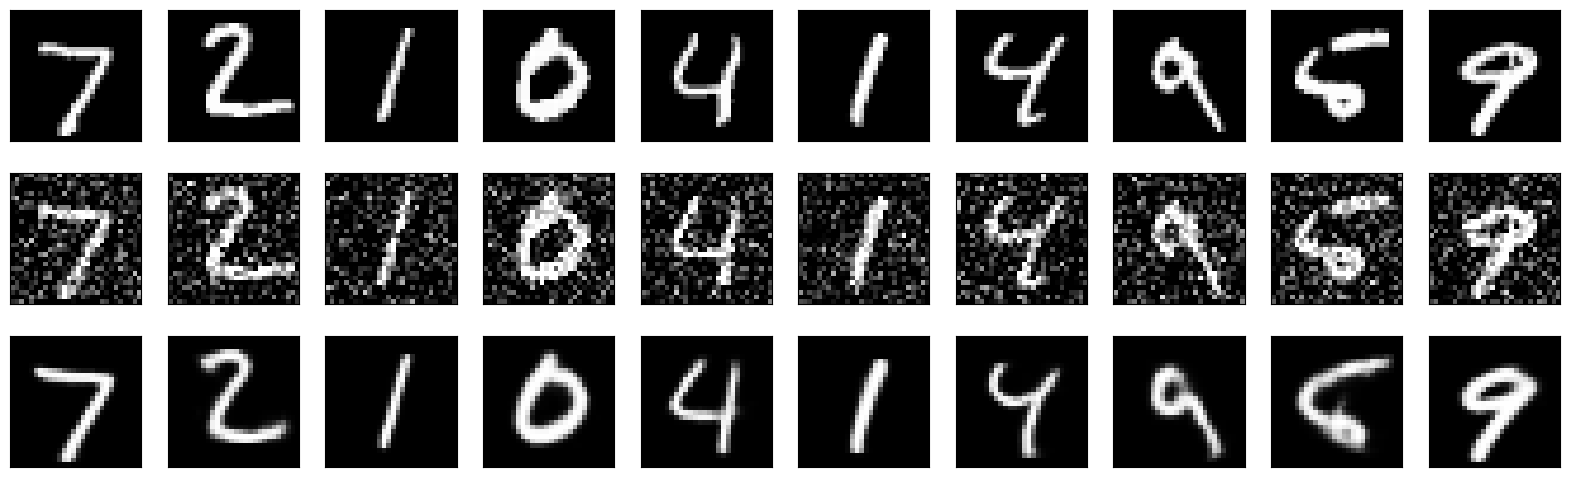

In [10]:
import matplotlib.pyplot as plt

# Predict the denoised images
denoised_images = new_diffusion_model.predict(x_test_noisy)

# Visualize the results
n = 10  # Number of digits to display
plt.figure(figsize=(20, 6))
for i in range(n):
    # Display original
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display noisy
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(x_test_noisy[i].reshape(28, 28), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display denoised
    ax = plt.subplot(3, n, i + 1 + 2*n)
    plt.imshow(denoised_images[i].reshape(28, 28), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

**noise 값과 모델에 인코도와 디코더 layer 를 추가했더니 더욱 정밀한, 정답을 추론할 수 있는 diffusion model을 생성 할 수 있게됨**

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


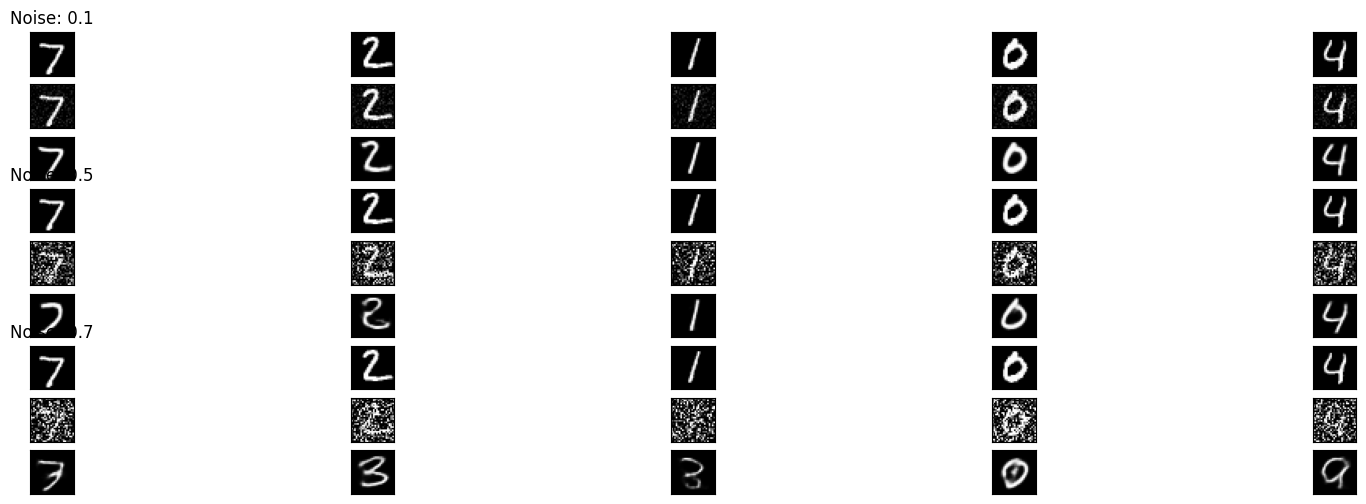

In [11]:
#Exercise 3 : Visualize the effect of noise
#           : Compare the impact of different noise levels on the denoising performance
#             of the model.
# Compare the impact of different noise levels on the denoising performance of the model
# Instruction : Add noise with different factors (e.g 0.1, 0.5, 0.7)
#               Use the model to predict the denoised images for each noise level
#               Visualize the origin, denoised images side by side for each noise level.

import matplotlib.pyplot as plt

def add_noise_and_predict(noise_factor):
    x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)
    x_test_noisy = np.clip(x_test_noisy, 0.0, 1.0)
    denoised_images = new_diffusion_model.predict(x_test_noisy)
    return x_test_noisy, denoised_images

# noise difference
noise_levels = [0.1,0.5,0.7]


# Visualise the results
n = 5 # Number of digits to display
plt.figure(figsize=(20, 6))

for idx, noise_factor in enumerate(noise_levels):
    x_test_noisy, denoised_images = add_noise_and_predict(noise_factor)
    for i in range(n):
    # Display original
        ax = plt.subplot(3 * len(noise_levels), n, i + 1 + idx * 3 * n)
        plt.imshow(x_test[i].reshape(28, 28), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        if i==0:
          ax.set_title(f"Noise: {noise_factor}")

        # Display noisy
        ax = plt.subplot(3 * len(noise_levels), n, i + 1 + n + idx * 3 * n)
        plt.imshow(x_test_noisy[i].reshape(28, 28), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

       # Display denoised
        ax = plt.subplot(3 * len(noise_levels), n, i + 1 + 2 * n + idx * 3 * n)
        plt.imshow(denoised_images[i].reshape(28, 28), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

plt.show()



**conclusion**

The key is the balance between noise level and model complexity.
When the noise is low and the model has a deep architecture, we can often observe higher accuracy.
However, to achieve good performance with deeper layers, it's essential to use proper training data, a suitable loss function, and appropriate regularisation techniques.

If the noise level is too low, the model might overfit by memorising the input too easily.
On the other hand, if the model is too deep, it may also lead to overfitting, slower training, or instability.
Therefore, finding the right balance between noise and model complexity is crucial.